# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
#from astropy.table import QTable
from numba import njit
from photutils import segmentation as segm
from scipy.spatial import ConvexHull

## 2. Read data

### select one dataset:

In [2]:
dataset = 3

1D spectra

2D images:

In [3]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [4]:
if dataset == 2:
    hdu = fits.open('data/CIG_335.fits')
    data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

3D datacubes:

In [5]:
if dataset == 3:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### visual inspection:

In [6]:
data_dimensionality = len(data.shape)

In [7]:
if data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data')
    ax = fig.subplots()

    im = ax.imshow(data,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95),
                  )
    ax.set_title('Input data')
    cb = fig.colorbar(im, ax=ax)

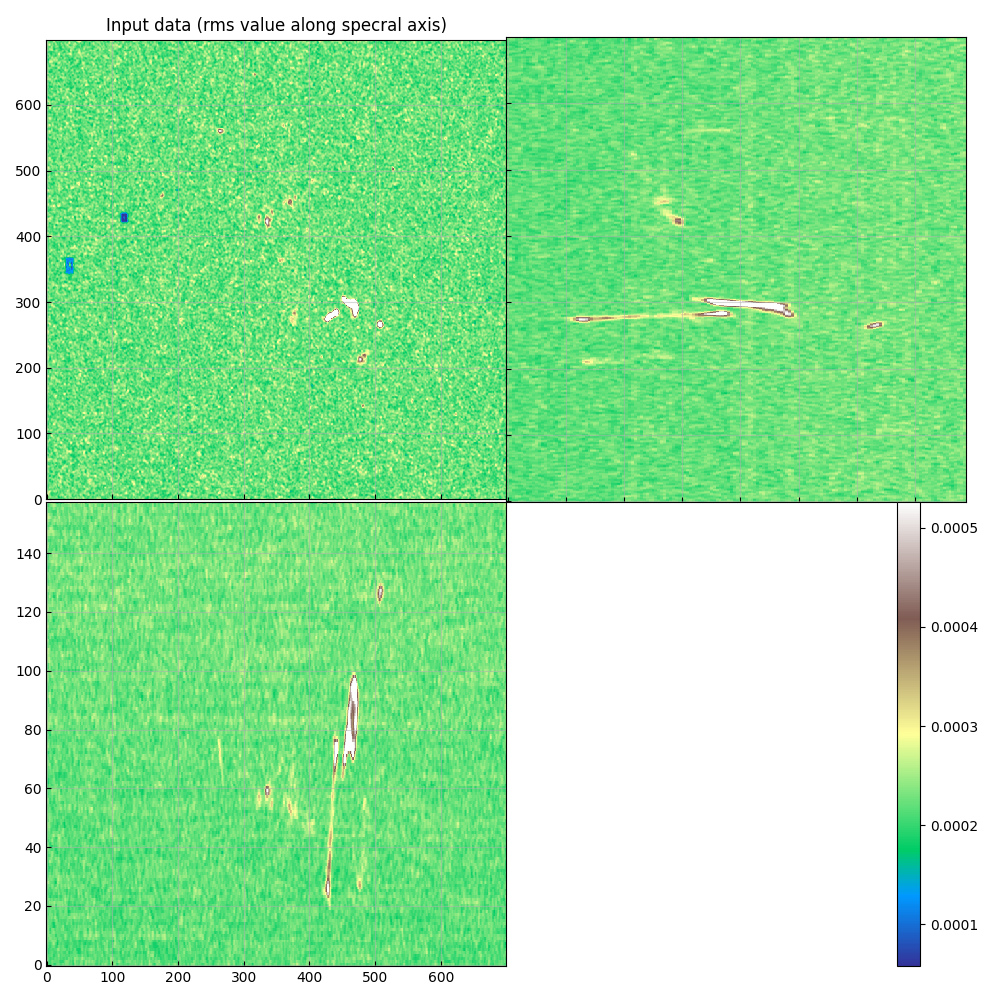

In [8]:
if data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    lo = np.nanpercentile(data, 60)
    hi = np.nanpercentile(data, 99)

    im = ax[0, 0].imshow(np.sqrt(np.nanmean(data**2, axis=0)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 0].set_title('Input data (rms value along specral axis)')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(data**2, axis=2)).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(data**2, axis=1)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_aspect('auto')
    
    cb = fig.colorbar(im, ax=ax[1, 1])
    ax[1, 1].set_visible(False)

## 3. Find mode

### cumulative mass:

I started with a generic function, including all data and allowing for statistical weights:

In [9]:
'''
sorted_by_data = np.argsort(data.flatten())
sorted_data = data.flatten()[sorted_by_data]

weights = np.ones_like(data, dtype=np.float64)
sorted_weight = weights.flatten()[sorted_by_data]

cumulative_mass = np.nancumsum(sorted_weight)
sorted_weight /= cumulative_mass[-1]
cumulative_mass /= cumulative_mass[-1]
'''

'\nsorted_by_data = np.argsort(data.flatten())\nsorted_data = data.flatten()[sorted_by_data]\n\nweights = np.ones_like(data, dtype=np.float64)\nsorted_weight = weights.flatten()[sorted_by_data]\n\ncumulative_mass = np.nancumsum(sorted_weight)\nsorted_weight /= cumulative_mass[-1]\ncumulative_mass /= cumulative_mass[-1]\n'

However, it is much more efficient to keep just a fraction of the data:

In [10]:
sorted_data_step = max([1, int(np.sqrt(data.size)/10)])
sorted_data = np.concatenate([np.sort(data.flatten())[::sorted_data_step], [np.nanmax(data)]])
cumulative_mass = np.arange(sorted_data.size) / sorted_data.size

This yields more than enough data points:

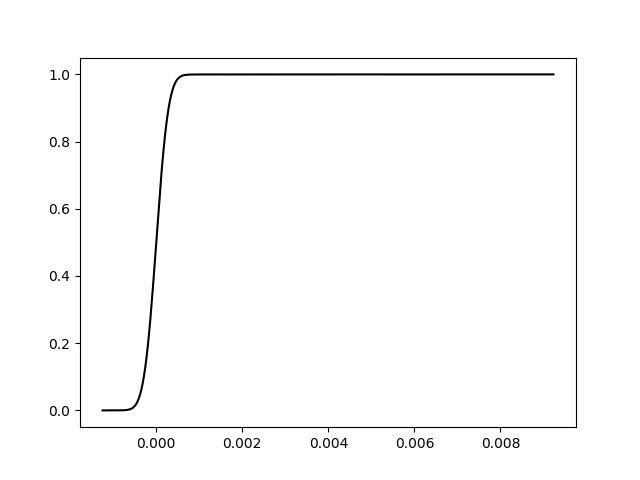

In [45]:
plt.close('cumulative_mass')
fig = plt.figure('cumulative_mass')
ax = fig.subplots()

ax.plot(sorted_data, cumulative_mass, 'k-')

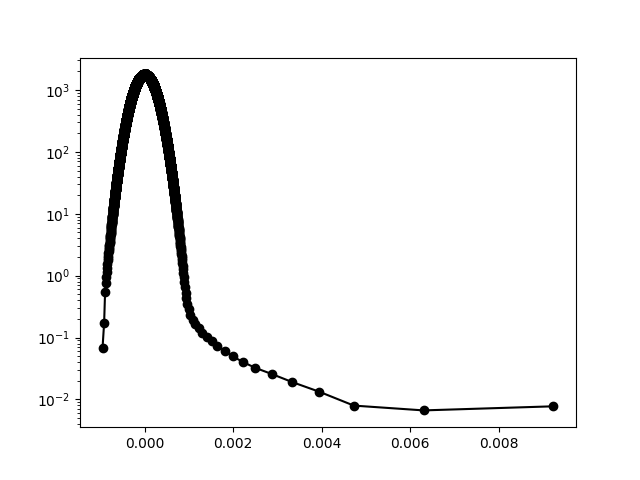

In [56]:
plt.close('density')
fig = plt.figure('density')
ax = fig.subplots()

n_bins = sorted_data.size
f_n = np.arange(1, n_bins)/n_bins
x_n = np.interp(f_n, cumulative_mass, sorted_data)
df = np.sqrt(f_n*(1-f_n)/n_bins)
x_min = np.interp(f_n-df, cumulative_mass, sorted_data)
x_max = np.interp(f_n+df, cumulative_mass, sorted_data)
x_mid = (x_max + x_min) / 2
rho = 2*df/(x_max-x_min)

ax.plot(x_n, rho, 'k-o')
ax.set_yscale('log')

In [50]:
f_n

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

### density peak (mode of the probability distribution):
Here we have a couple of free parameters:

In [12]:
delta = .5  # relative size of the smoothing kernel (delta <= 1)

# mass fractions to be tested:
m = np.linspace(delta**2,  # somewhat arbitrary :^(
                1/(1+delta),  # do not overshoot
                int(np.sqrt(data.size)) # a reasonable number of trials
               )

Find maximum:

In [13]:
x_top = np.interp((1+delta)*m, cumulative_mass, sorted_data)
x_mid = np.interp(m, cumulative_mass, sorted_data)
x_bot = np.interp((1-delta)*m, cumulative_mass, sorted_data)
rho_top = delta * m / (x_top - x_mid)
rho_bot = delta * m / (x_mid - x_bot)
peak = np.nanargmin((rho_top - rho_bot) ** 2)
data_mode = x_mid[peak]

Text(0.5, 1.0, 'delta = 0.5')

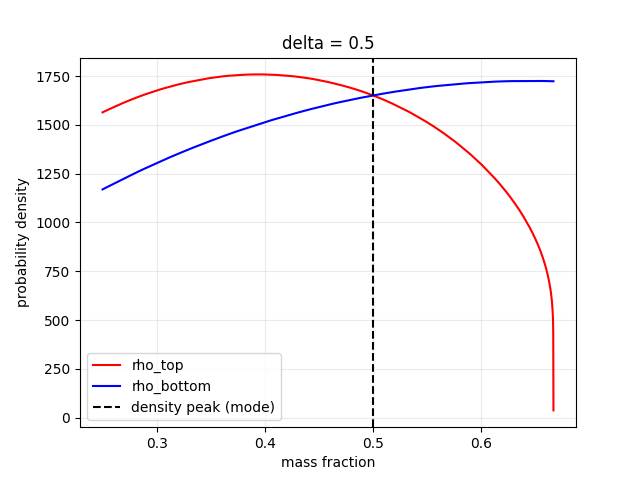

In [14]:
plt.close('density')
fig = plt.figure('density')
ax = fig.subplots()

ax.plot(m, rho_top, 'r-', label='rho_top')
ax.plot(m, rho_bot, 'b-', label='rho_bottom')
ax.axvline(m[peak], c='k', ls='--', label='density peak (mode)')

ax.grid(alpha=.25)
ax.legend()
ax.set_xlabel('mass fraction')
ax.set_ylabel('probability density')
ax.set_title(f'delta = {delta}')

### estimate source threshold:

In [15]:
print(f'data_mode = {data_mode:.3g}')

m_background = 2 * m[peak]
m_signal = 1 - m_background
threshold_guess = np.interp(m_background, cumulative_mass, sorted_data)
print(f'm_background={m_background:.3g}, m_signal={m_signal:.3g}, old threshold_guess={threshold_guess:.3g}')

m_above = 1 - cumulative_mass
m_symmetric_above = np.interp(2 * data_mode - sorted_data, sorted_data, cumulative_mass, left=0.)
left = np.where(sorted_data < data_mode)
m_symmetric_above[left] = m_background - cumulative_mass[left]
m_signal_above = m_above - m_symmetric_above
purity = m_signal_above / (m_above+1e-30)
purity[-1] = 1

threshold_guess = np.interp(0.5, purity, sorted_data)
delta_th = threshold_guess-data_mode
print(f'threshold_guess={threshold_guess:.3g}, delta_th={delta_th:.3g}')
bg_std = np.std(data[data < data_mode])
print(f'background std={bg_std:.3g} => delta_th={delta_th/bg_std:.3g} sigmas')


data_mode = 6.63e-07
m_background=1, m_signal=1.89e-05, old threshold_guess=0.00727
threshold_guess=0.000774, delta_th=0.000773
background std=0.000135 => delta_th=5.71 sigmas


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-0.0012467269552871585, 0.0037428343945596397)

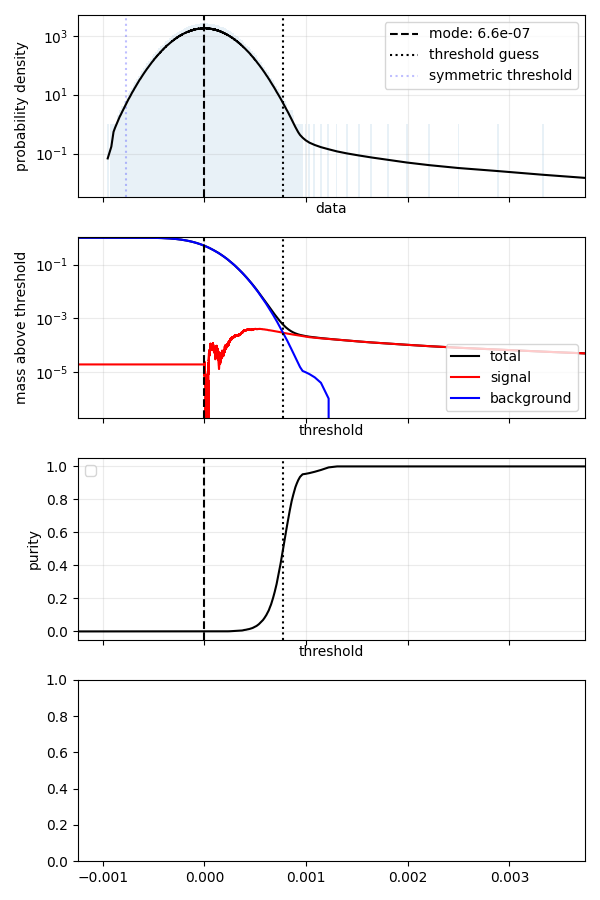

In [59]:
L = max(data_mode-sorted_data[0], threshold_guess-data_mode)

plt.close('statistics')
fig = plt.figure('statistics', figsize=(6, 9))
fig.set_tight_layout(True)
ax = fig.subplots(nrows=4, sharex=True)

# density:

ax[0].hist(sorted_data, bins=np.linspace(sorted_data[0], data_mode + 3*L, int(np.sqrt(sorted_data.size))), alpha=.1)
ax[0].axvline(data_mode, c='k', ls='--', label=f'mode: {data_mode:.2g}')
ax[0].axvline(threshold_guess, c='k', ls=':', label='threshold guess')
ax[0].axvline(2*data_mode-threshold_guess, c='b', ls=':', alpha=.25, label='symmetric threshold')
ax[0].plot(x_n, rho, 'k-')

ax[0].grid(alpha=.25)
ax[0].legend()
ax[0].set_xlabel('data')
ax[0].set_ylabel('probability density')
ax[0].set_yscale('log')

# mass:

ax[1].plot(sorted_data, m_above, 'k-', label='total')
ax[1].plot(sorted_data, m_signal_above, 'r-', label='signal')
ax[1].plot(sorted_data, m_symmetric_above, 'b-', label='background')
ax[1].axvline(data_mode, c='k', ls='--')
ax[1].axvline(threshold_guess, c='k', ls=':')

ax[1].grid(alpha=.25)
ax[1].legend(loc='lower right')
ax[1].set_xlabel('threshold')
ax[1].set_xlim(sorted_data[0], data_mode + 5*L)
ax[1].set_ylabel('mass above threshold')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-2*m_signal, 1.1)

# purity:

ax[2].plot(sorted_data, purity, 'k-')
ax[2].axvline(data_mode, c='k', ls='--')
ax[2].axvline(threshold_guess, c='k', ls=':')

ax[2].grid(alpha=.25)
ax[2].legend()
ax[2].set_xlabel('threshold')
ax[2].set_ylabel('purity')

ax[0].set_xlim(sorted_data[0], data_mode + 3*L)

## 3. Hierarchical Overdensity Tree (HOT)

### routine definition:

In [17]:
@njit
def hot(data, threshold=-np.inf):
    """Hierarchical Overdenity Tree (HOT)"""

    flat_data = data.flatten()
    strides = np.array(data.strides)//data.itemsize

    label = np.zeros(data.size, dtype=np.int64)
    n_labels = 0
    parent = np.zeros(data.size, dtype=np.int64)
    area = np.zeros(data.size, dtype=np.int64)
    max_value = np.zeros_like(flat_data)
    saddle_value = np.full_like(max_value, threshold)
    saddle_area = np.zeros(data.size, dtype=np.int64)

    for pixel in np.argsort(flat_data)[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        if np.isnan(pixel_value):
            continue
        if pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < flat_data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
            max_value[n_labels] = pixel_value
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent
                if saddle_area[p] == 0:
                    saddle_value[p] = pixel_value
                    saddle_area[p] = area[p]+1
            #saddle_area[selected_parent] -= 1

        label[pixel] = selected_parent
        area[selected_parent] += 1
        #saddle_area[selected_parent] += 1
        if saddle_area[selected_parent] == 0:
            saddle_value[selected_parent] = pixel_value
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[:n_labels+1] == np.arange(n_labels+1))
    single = np.where(
        (parent[:n_labels+1] == np.arange(n_labels+1))
        &
        (saddle_area[:n_labels+1] == 0)
    )
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size -1} independent regions',
          f'({single[0].size -1} of them single peaks)',
         )
    area[0] = saddle_area[0] = data.size-n_src
    saddle_area[single] = area[single]
    max_value[0] = saddle_value[0] = threshold
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_value[:n_labels+1],
               saddle_value[:n_labels+1],
               saddle_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


In [18]:
@njit
def hot(data, threshold=-np.inf, min_std=0):
    """Hierarchical Overdenity Tree (HOT)"""

    min_variance = min_std**2
    
    flat_data = data.flatten()
    strides = np.array(data.strides)//data.itemsize

    label = np.zeros(data.size, dtype=np.int64)
    n_labels = 0
    parent = np.zeros(data.size, dtype=np.int64)
    area = np.zeros(data.size, dtype=np.int64)
    max_value = np.zeros_like(flat_data)
    saddle_value = np.full_like(max_value, threshold)
    saddle_area = np.zeros(data.size, dtype=np.int64)
    mean_value = np.zeros(data.size, dtype=np.int64)
    std_value = np.zeros(data.size, dtype=np.int64)

    for pixel in np.argsort(flat_data)[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        if np.isnan(pixel_value):
            continue
        if pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < flat_data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
            max_value[n_labels] = pixel_value
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                var_value = (std_value[p]+pixel_value**2)/(area[p]+1) - ((mean_value[p]+pixel_value)/(area[p]+1))**2
                if var_value >= min_variance:
                    parent[p] = selected_parent
                    if saddle_area[p] == 0:
                        saddle_value[p] = pixel_value
                        saddle_area[p] = area[p]+1
                else:
                    print(f'merge {p} into {selected_parent}!')
                    if p != selected_parent:
                        parent[p] = 0
                        label[label == p] = selected_parent
                        mean_value[selected_parent] += mean_value[p]
                        std_value[selected_parent] += std_value[p]
                        if max_value[selected_parent] < max_value[p]:
                            max_value[selected_parent] = max_value[p]
                    
        label[pixel] = selected_parent
        area[selected_parent] += 1
        mean_value[selected_parent] += pixel_value
        std_value[selected_parent] += pixel_value**2
        #saddle_area[selected_parent] += 1
        if saddle_area[selected_parent] == 0:
            saddle_value[selected_parent] = pixel_value
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[:n_labels+1] == np.arange(n_labels+1))
    single = np.where(
        (parent[:n_labels+1] == np.arange(n_labels+1))
        &
        (saddle_area[:n_labels+1] == 0)
    )
    print(f'{n_labels} overdensities found, {np.count_nonzero(parent[:n_labels+1])} kept:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size -1} independent',
          f'({single[0].size -1} of them single peaks)',
         )
    area[0] = saddle_area[0] = data.size-n_src
    saddle_area[single] = area[single]
    max_value[0] = saddle_value[0] = threshold
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_value[:n_labels+1],
               saddle_value[:n_labels+1],
               saddle_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### normal and inverted catalogues:

In [19]:
'''
label, catalog = hot(data-data_mode, threshold_guess)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_value = catalog[2]
saddle_value = catalog[3]
saddle_area = catalog[4]

label_inv, catalog_inv = hot(data_mode-data, threshold_guess)
segmentation_inv = segm.SegmentationImage(label_inv)
parent_inv = catalog_inv[0]
area_inv = catalog_inv[1]
max_value_inv = catalog_inv[2]
saddle_value_inv = catalog_inv[3]
saddle_area_inv = catalog_inv[4]
'''


'\nlabel, catalog = hot(data-data_mode, threshold_guess)\nsegmentation = segm.SegmentationImage(label)\nparent = catalog[0]\narea = catalog[1]\nmax_value = catalog[2]\nsaddle_value = catalog[3]\nsaddle_area = catalog[4]\n\nlabel_inv, catalog_inv = hot(data_mode-data, threshold_guess)\nsegmentation_inv = segm.SegmentationImage(label_inv)\nparent_inv = catalog_inv[0]\narea_inv = catalog_inv[1]\nmax_value_inv = catalog_inv[2]\nsaddle_value_inv = catalog_inv[3]\nsaddle_area_inv = catalog_inv[4]\n'

In [20]:
label, catalog = hot(data-data_mode, bg_std)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_value = catalog[2]
saddle_value = catalog[3]
saddle_area = catalog[4]

label_inv, catalog_inv = hot(data_mode-data, bg_std)
segmentation_inv = segm.SegmentationImage(label_inv)
parent_inv = catalog_inv[0]
area_inv = catalog_inv[1]
max_value_inv = catalog_inv[2]
saddle_value_inv = catalog_inv[3]
saddle_area_inv = catalog_inv[4]
'''
'''


577667 overdensities found, 577667 kept: 21149341 "pixels" (27%), 26129 independent (20761 of them single peaks)
578240 overdensities found, 578240 kept: 21147451 "pixels" (27%), 25745 independent (20393 of them single peaks)


'\n'

In [21]:
np.unique(label).size

577668

I tried to predict the probability distribution of max_value and saddle value, given saddle_area. In the former, I more or less succeeded...

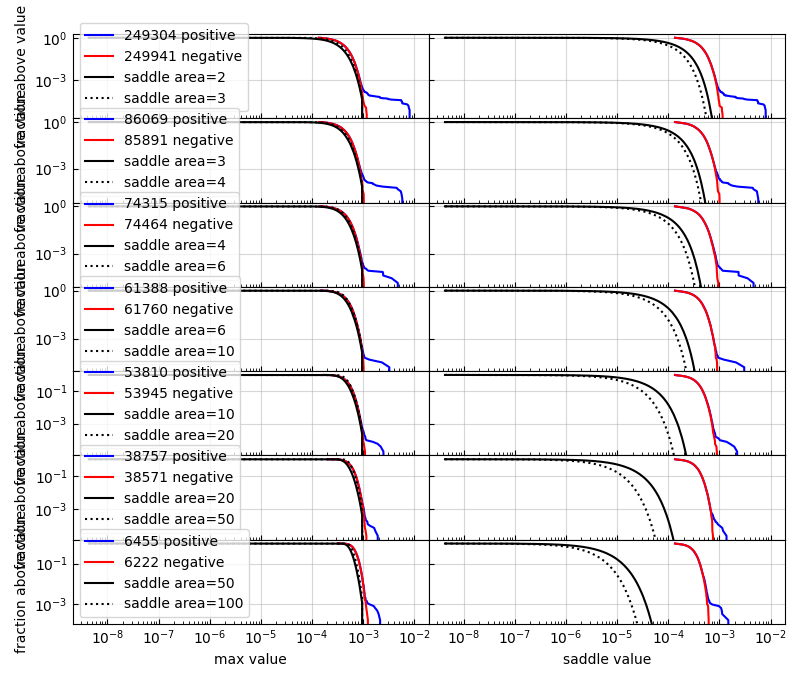

In [22]:
if data_dimensionality < 4:
    plot_areas_edges = [2, 3, 4, 6, 10, 20, 50, 100]
    x_bg = data_mode - sorted_data[sorted_data < data_mode][::-1]
    P_bg = (np.arange(x_bg.size)+1)/x_bg.size

    plt.close('selection model')
    fig = plt.figure('selection model', figsize=(8, 4+np.sqrt(len(plot_areas_edges))))
    ax = fig.subplots(nrows=len(plot_areas_edges)-1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)


    for i in range(len(plot_areas_edges)-1):
        ax[i, 0].set_ylabel('fraction above value')
        ax[i, 0].set_yscale('log')

        n0 = plot_areas_edges[i]
        n1 = plot_areas_edges[i+1]
        selected_regions = np.where((saddle_area >= n0) & (saddle_area < n1))
        seleced_max = np.sort(max_value[selected_regions])
        seleced_saddle = np.sort(saddle_value[selected_regions])
        selected_regions_inv = np.where((saddle_area_inv >= n0) & (saddle_area_inv < n1))
        seleced_max_inv = np.sort(max_value_inv[selected_regions_inv])
        seleced_saddle_inv = np.sort(saddle_value_inv[selected_regions_inv])

        f = np.arange(seleced_max.size)[::-1]/seleced_max.size
        ax[i, 0].plot(seleced_max, f, 'b-', label=f'{seleced_max.size} positive')
        f = np.arange(seleced_max_inv.size)[::-1]/seleced_max_inv.size
        ax[i, 0].plot(seleced_max_inv, f, 'r-', label=f'{seleced_max_inv.size} negative')
        ax[i, 0].plot(x_bg, 1-P_bg**n0, 'k-', label=f'saddle area={n0}')
        ax[i, 0].plot(x_bg, 1-P_bg**n1, 'k:', label=f'saddle area={n1}')

        f = np.arange(seleced_saddle.size)[::-1]/seleced_saddle.size
        ax[i, 1].plot(seleced_saddle, f, 'b-', label='positive')
        f = np.arange(seleced_saddle_inv.size)[::-1]/seleced_saddle_inv.size
        ax[i, 1].plot(seleced_saddle_inv, f, 'r-', label='negative')
        ax[i, 1].plot(x_bg, (1-P_bg)**n0, 'k-', label=f'saddle area={n0}')
        ax[i, 1].plot(x_bg, (1-P_bg)**n1, 'k:', label=f'saddle area={n1}')

        ax[i, 0].legend(loc='lower left')
        #ax[i, 0].set_ylim(1/n_regions, 1)

    ax[-1, 0].set_xlabel('max value')
    ax[-1, 1].set_xlabel('saddle value')
    ax[-1, 0].set_xscale('log')
    #ax[-1, 0].set_xlim(x_bg[-1]/100, x_bg[-1])


## 4. Object selection

### estimate thresholds:

Compute upper hulls in log(max_value) and log(saddle_value) as a funtion of log(saddle area) for the "inverted" data:

In [23]:
def upper_hull(x, y):
    """Compute upper hull"""
    
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]


log_sarea_inv = np.log(saddle_area_inv[parent_inv != 0])
log_max_inv = np.log(max_value_inv[parent_inv != 0])
log_svalue_inv = np.log(saddle_value_inv[parent_inv != 0])
max_hull_x, max_hull_y = upper_hull(log_sarea_inv, log_max_inv)
saddle_hull_x, saddle_hull_y = upper_hull(log_sarea_inv, log_svalue_inv)

Let's go for a more aggressive threshold:

In [24]:
log_sarea = np.log(saddle_area[parent != 0])
log_max = np.log(max_value[parent != 0])
log_svalue = np.log(saddle_value[parent != 0])

max_cut = np.interp(log_sarea, max_hull_x, max_hull_y)
max_cut_inv = np.interp(log_sarea_inv, max_hull_x, max_hull_y)
saddle_cut = np.interp(log_sarea, saddle_hull_x, saddle_hull_y)
saddle_cut_inv = np.interp(log_sarea_inv, saddle_hull_x, saddle_hull_y)

cut_bins = np.linspace(0, 1, 51)
cut_mid = (cut_bins[1:] + cut_bins[:-1]) / 2

max_hist, cut_bins = np.histogram(np.exp(log_max-max_cut), bins=cut_bins, density=True)
max_hist_inv, cut_bins = np.histogram(np.exp(log_max_inv-max_cut_inv), bins=cut_bins, density=True)
max_threshold = np.max(cut_mid[max_hist < 3*max_hist_inv])
print(f'select objects above {100*max_threshold:.1f}% of max_value upper hull')

saddle_hist, cut_bins = np.histogram(np.exp(log_svalue-saddle_cut), bins=cut_bins, density=True)
saddle_hist_inv, cut_bins = np.histogram(np.exp(log_svalue_inv-saddle_cut_inv), bins=cut_bins, density=True)
saddle_threshold = np.max(cut_mid[saddle_hist < 3*saddle_hist_inv])
#saddle_threshold = 1
print(f'select objects above {100*saddle_threshold:.1f}% of saddle_value upper hull')


select objects above 99.0% of max_value upper hull
select objects above 99.0% of saddle_value upper hull


/tmp/ipykernel_71119/3805108395.py:17: RuntimeWarning: invalid value encountered in true_divide
  ax[1, 0].plot(cut_mid, np.clip(max_hist-max_hist_inv, 0, np.inf)/(max_hist+max_hist_inv), 'k-')
/tmp/ipykernel_71119/3805108395.py:25: RuntimeWarning: invalid value encountered in true_divide
  ax[1, 1].plot(cut_mid, np.clip(saddle_hist-saddle_hist_inv, 0, np.inf)/(saddle_hist+saddle_hist_inv), 'k-')


Text(0.5, 0, 'saddle_value / upper hull')

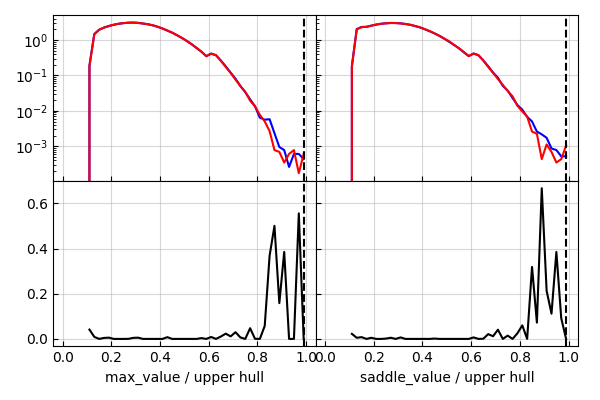

In [25]:
plt.close('cut-based')
fig = plt.figure('cut-based', figsize=(6, 4))
ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)


ax[0, 0].plot(cut_mid, max_hist, 'b-')
ax[0, 0].plot(cut_mid, max_hist_inv, 'r-')
ax[0, 0].axvline(max_threshold, c='k', ls='--')
ax[0, 0].set_yscale('log')

ax[1, 0].plot(cut_mid, np.clip(max_hist-max_hist_inv, 0, np.inf)/(max_hist+max_hist_inv), 'k-')
ax[1, 0].axvline(max_threshold, c='k', ls='--')


ax[0, 1].plot(cut_mid, saddle_hist, 'b-')
ax[0, 1].plot(cut_mid, saddle_hist_inv, 'r-')
ax[0, 1].axvline(saddle_threshold, c='k', ls='--')

ax[1, 1].plot(cut_mid, np.clip(saddle_hist-saddle_hist_inv, 0, np.inf)/(saddle_hist+saddle_hist_inv), 'k-')
ax[1, 1].axvline(saddle_threshold, c='k', ls='--')

ax[1, 0].set_xlabel('max_value / upper hull')
ax[1, 1].set_xlabel('saddle_value / upper hull')

### apply threshod-based selection criteria:

In [26]:
x_bg = data_mode - sorted_data[sorted_data < data_mode][::-1]
P_bg = (np.arange(x_bg.size)+1)/x_bg.size

n_pixels = 10**np.arange(0, np.log10(data.size), .1)
cut_max = np.empty_like(n_pixels)
cut_saddle = np.empty_like(n_pixels)
for i, n in enumerate(n_pixels):
    p = 1-P_bg**n
    cut_max[i] = np.interp(1/area_inv.size, p[::-1], x_bg[::-1]) 
    p = (1-P_bg)**n
    cut_saddle[i] = np.interp(1/area_inv.size, p[::-1], x_bg[::-1]) 


In [27]:
selected = np.where(saddle_value > np.interp(saddle_area, n_pixels, cut_saddle))
print(f'{selected[0].size} overdensities pass the selection criteria')

selected = np.where(
    (saddle_value > np.interp(saddle_area, n_pixels, cut_saddle))
    |
    (saddle_value > np.interp(saddle_area, n_pixels, cut_saddle))
)
print(f'{selected[0].size} overdensities pass the selection criteria')

selected = np.where(
    (log_max > np.log(max_threshold) + max_cut)
    |
    (log_svalue > np.log(saddle_threshold) + saddle_cut)
)
print(f'{selected[0].size} overdensities pass the selection criteria')

valid_labels = -np.arange(parent.size)
valid_labels[selected] = 0
valid_labels += np.arange(parent.size)
valid_labels = valid_labels[label]
thresold_selection = segm.SegmentationImage(valid_labels)

141756 overdensities pass the selection criteria
141756 overdensities pass the selection criteria
98 overdensities pass the selection criteria


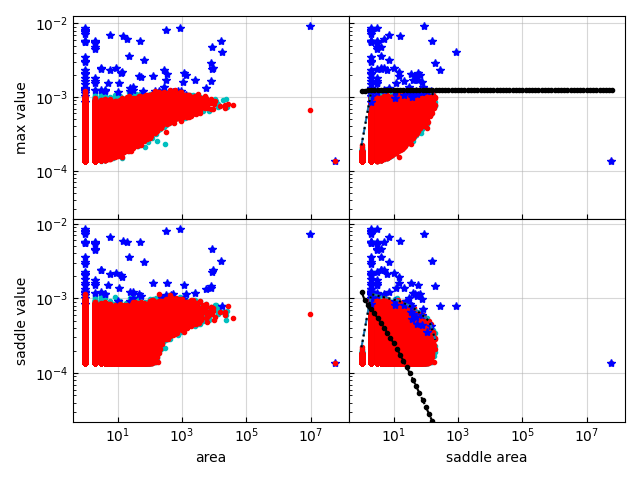

In [28]:
plt.close('selection')
fig = plt.figure('selection')
ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

ax[0, 0].set_ylabel('max value')
ax[0, 0].set_yscale('log')
ax[0, 0].plot(catalog[1], catalog[2], 'c.')
ax[0, 0].plot(catalog[1][selected], catalog[2][selected], 'b*')
ax[0, 0].plot(catalog_inv[1], catalog_inv[2], 'r.')

ax[1, 0].set_ylabel('saddle value')
ax[1, 0].set_yscale('log')
ax[1, 0].plot(catalog[1], catalog[3], 'c.')
ax[1, 0].plot(catalog[1][selected], catalog[3][selected], 'b*')
ax[1, 0].plot(catalog_inv[1], catalog_inv[3], 'r.')

ax[-1, 0].set_xlabel('area')
ax[-1, 0].set_xscale('log')


ax[0, 1].plot(catalog[4], catalog[2], 'c.')
ax[0, 1].plot(catalog_inv[4], catalog_inv[2], 'r.')
ax[0, 1].plot(catalog[4][selected], catalog[2][selected], 'b*')
ax[0, 1].plot(np.exp(max_hull_x), np.exp(max_hull_y), '--')
ax[0, 1].plot(np.exp(max_hull_x), max_threshold*np.exp(max_hull_y), 'k:')
ax[0, 1].plot(n_pixels, cut_max, 'k--.')
ax[0, 1].set_ylim(.1*max_threshold*np.exp(np.min(max_hull_y)), 10*np.exp(np.max(max_hull_y)))

ax[1, 1].plot(catalog[4], catalog[3], 'c.')
ax[1, 1].plot(catalog_inv[4], catalog_inv[3], 'r.')
ax[1, 1].plot(catalog[4][selected], catalog[3][selected], 'b*')
ax[1, 1].plot(np.exp(saddle_hull_x), np.exp(saddle_hull_y), '--')
ax[1, 1].plot(np.exp(saddle_hull_x), saddle_threshold*np.exp(saddle_hull_y), 'k:')
ax[1, 1].plot(n_pixels, cut_saddle, 'k--.')
ax[1, 1].set_ylim(.1*saddle_threshold*np.exp(np.min(saddle_hull_y)), 10*np.exp(np.max(saddle_hull_y)))

ax[-1, 1].set_xlabel('saddle area')
ax[-1, 1].set_xscale('log')

In [29]:
if data_dimensionality == 2:
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data-data_mode,
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        segmentation,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title(f'Threshold selection\n({selected[0].size} objects)')
    im = ax[0, 2].imshow(
        thresold_selection,
        interpolation='nearest', origin='lower', cmap=thresold_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    ax[1, 0].set_title('Max value')
    im = ax[1, 0].imshow(
        max_value[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('Saddle value')
    im = ax[1, 1].imshow(
        saddle_value[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Saddle area')
    im = ax[1, 2].imshow(
        saddle_area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


## 5. Mode filter

In [30]:
@njit
def mode_filter(data):
    flat_data = data.flatten()
    mode = np.empty_like(flat_data)
    count = np.empty_like(flat_data)
    strides = np.array(data.strides)//data.itemsize
    neighbours = np.empty(2*len(strides)+1, dtype=np.int64)
    counts = np.empty_like(neighbours)
    n_changes = 0
    
    for pixel in range(flat_data.size):
        #print('>', pixel)
        neighbours[0] = flat_data[pixel]
        counts[0] = 1
        n_neighbours = 1
        for stride in strides:
            if pixel >= stride:
                #print(-stride)
                value = flat_data[pixel-stride]
                n = 0
                while True:
                    if value == neighbours[n]:
                        counts[n] += 1
                        break
                    else:
                        n += 1
                        if n == n_neighbours:
                            neighbours[n] = value
                            counts[n] = 1
                            n_neighbours += 1
                            break
            if pixel+stride < flat_data.size:
                value = flat_data[pixel+stride]
                #print(stride, value)
                n = 0
                while True:
                    if value == neighbours[n]:
                        counts[n] += 1
                        break
                    else:
                        n += 1
                        if n == n_neighbours:
                            neighbours[n] = value
                            counts[n] = 1
                            n_neighbours += 1
                            break
        best = np.argmax(counts[:n_neighbours])
        if counts[best] == counts[0]: # just in case
            best = 0
        else:
            n_changes += 1
        #print(f'> pixel {pixel} moves from {neighbours[0]} to {neighbours[best]} (out of {n_neighbours} possibilities)')
        mode[pixel] = neighbours[best]
        count[pixel] = counts[best]
        
    return mode.reshape(data.shape), count.reshape(data.shape), n_changes


In [31]:
filtered_labels = np.copy(valid_labels)
n_old = 0
n = filtered_labels.size
while n != n_old:
    n_old = n
    filtered_labels, c, n = mode_filter(filtered_labels)
    print(n, 'changes')

6530779 changes
2009924 changes
760483 changes
302789 changes
119038 changes
48301 changes
20795 changes
9669 changes
4802 changes
2522 changes
1444 changes
830 changes
521 changes
345 changes
246 changes
205 changes
174 changes
153 changes
137 changes
130 changes
126 changes
123 changes
122 changes
121 changes
121 changes


In [32]:
final_labels = np.copy(filtered_labels)
unique_labels = np.unique(filtered_labels)
n_final_labels = unique_labels.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(unique_labels):
    final_labels[final_labels == lbl] = i
final_selection = segm.SegmentationImage(final_labels)

50 objects after mode filtering


In [33]:
if data_dimensionality == 2:
    final_catalog = segm.SourceCatalog(data, final_selection)
    final_catalog.to_table()

In [34]:
if data_dimensionality == 2:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data-data_mode,
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-3*delta_th, linthresh=3*delta_th, vmax=np.nanpercentile(data-data_mode, 99.9)),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')

    ax[0, 1].set_title(f'Final selection map\n({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')


/tmp/ipykernel_71119/1716142304.py:44: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),


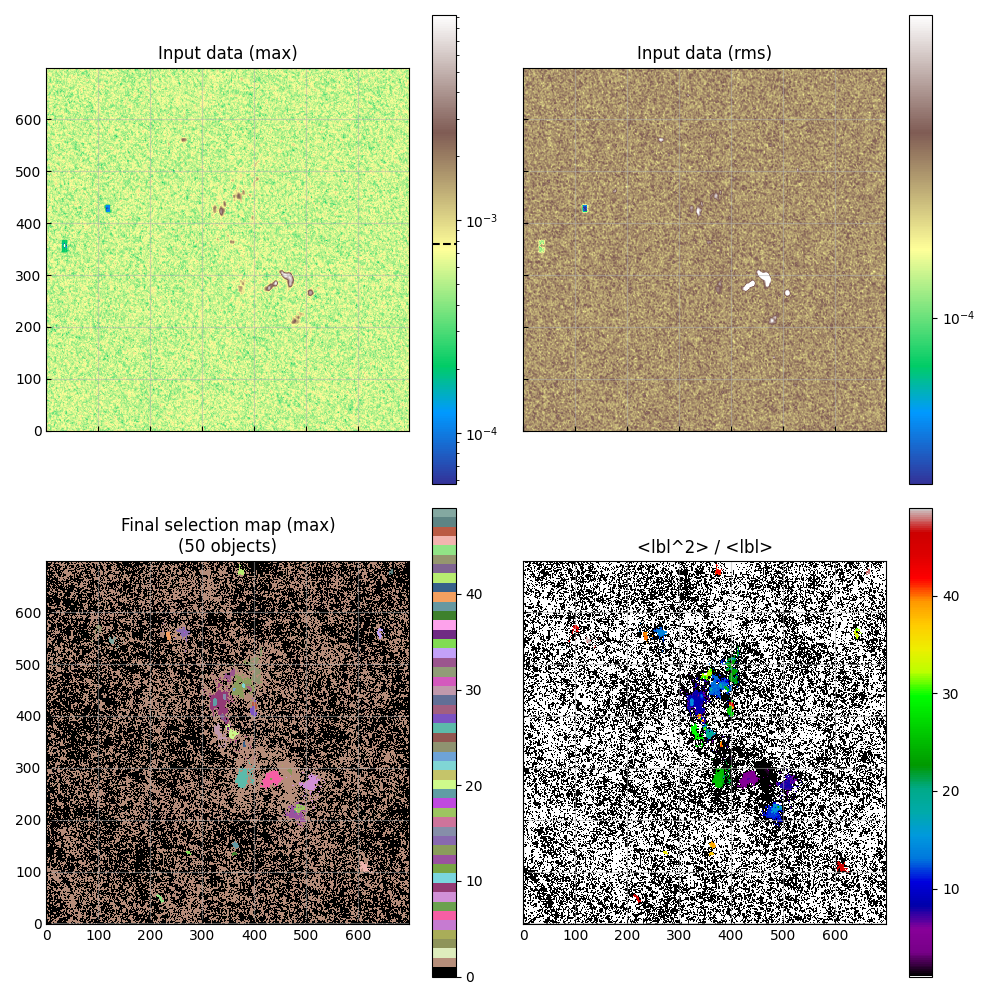

In [35]:
if data_dimensionality == 3:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data-data_mode, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.LogNorm(vmin=np.nanpercentile(data, 60))
    )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-data_mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        norm = colors.SymLogNorm(vmin=np.nanpercentile(data, 60), linthresh=delta_th/10, vmax=np.nanpercentile(data, 99))
    )
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        np.nanmax(final_selection, axis=0),
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


/tmp/ipykernel_71119/1812969284.py:27: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(section_labels**2, axis=2).T / np.nansum(section_labels, axis=2).T,
/tmp/ipykernel_71119/1812969284.py:64: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(section_labels**2, axis=1).T / np.nansum(section_labels, axis=1).T,


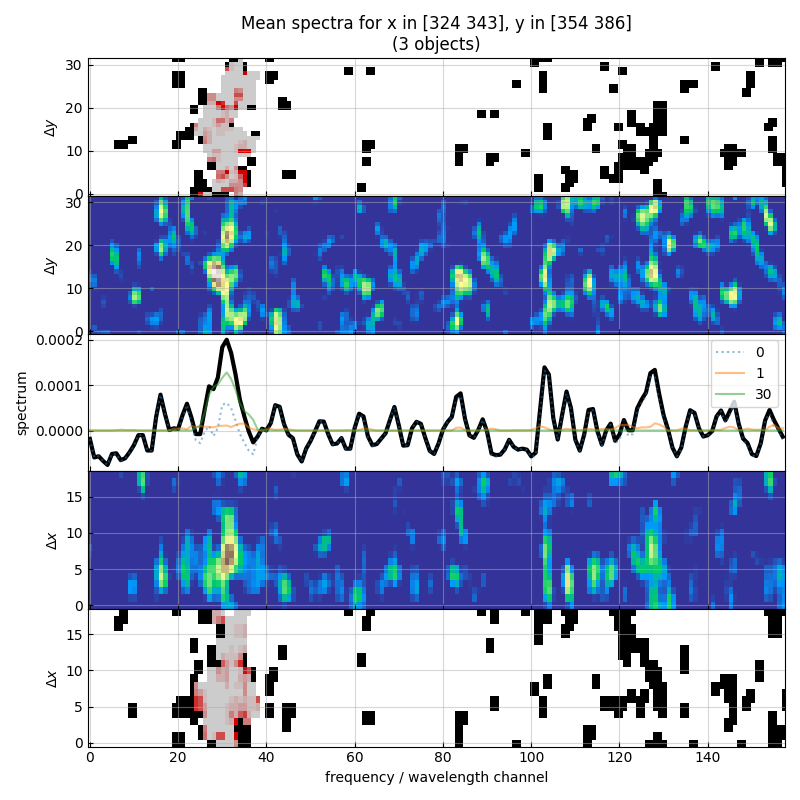

In [44]:
if data_dimensionality == 3:
    lo = np.nanpercentile(data, 60)
    hi = np.nanpercentile(data, 99)
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        np.nansum(section_labels**2, axis=2).T / np.nansum(section_labels, axis=2).T,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        np.nansum(section_labels**2, axis=1).T / np.nansum(section_labels, axis=1).T,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')
